# Loading code and data

## When loading notebook for the first time:

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [14]:
########################################
########## Add kaggle API key ##########
########################################

!echo '' > ~/.kaggle/kaggle.json

In [15]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!git clone https://github.com/TigerManon/drive-on-mars.git

Cloning into 'drive-on-mars'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 135 (delta 49), reused 108 (delta 32), pack-reused 0
Receiving objects: 100% (135/135), 24.68 MiB | 11.19 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [8]:
%cd drive-on-mars/
%mkdir raw_data
%cd raw_data

/content/drive-on-mars
/content/drive-on-mars/raw_data


In [18]:
!kaggle datasets download yash92328/ai4mars-terrainaware-autonomous-driving-on-mars

100% 5.72G/5.72G [05:14<00:00, 19.2MB/s]
100% 5.72G/5.72G [05:14<00:00, 19.6MB/s]


In [20]:
!unzip -q ai4mars-terrainaware-autonomous-driving-on-mars.zip

In [22]:
!rm ai4mars-terrainaware-autonomous-driving-on-mars.zip

In [23]:
%cd ../

/content/drive-on-mars


## When reloading the notebook

In [22]:
%pwd

'/content/drive-on-mars'

In [23]:
%cd drive-on-mars/

[Errno 2] No such file or directory: 'drive-on-mars/'
/content/drive-on-mars


## Imports

# A quick Start for Unet Model Understanding


## Data Exploring


In [5]:
# !pip install git+https://github.com/qubvel/segmentation_models

In [7]:
# Data Visualisation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm


from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split


In [8]:
# Segmentation Models

############# Alice #################
# Had to add this to make sm work in colab
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
#####################################

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

Segmentation Models: using `tf.keras` framework.


In [9]:
images = "raw_data/ai4mars-dataset-merged-0.1/msl/images"
tr_lab = "raw_data/ai4mars-dataset-merged-0.1/msl/labels/train"


edr = images + "/edr"
#mxy = images + "/mxy" # not required
#rng = images + "/rng-30m" # not required

In [11]:
%%time

edr_files = sorted(os.listdir(edr))
trlab_files = sorted(os.listdir(tr_lab))

X = []
y = []
c = 0

# preparing X and y
for lab_name in trlab_files:
    img_name = lab_name[:-4] + ".JPG"

    if img_name in edr_files:

        img_path = os.path.join(edr, img_name)
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr, dsize = (256, 256))

        lab_path = os.path.join(tr_lab, lab_name)
        lab_arr = cv2.imread(lab_path, 0)
        lab_arr = cv2.resize(lab_arr, (256, 256), interpolation = cv2.INTER_NEAREST)

        X.append(img_arr)
        y.append(lab_arr)

    c += 1
    if c >= 12_000:
        break

X = np.asarray(X, dtype = np.float32) / 255.0
y = np.array(y, dtype = np.uint8)

# 0 - soil
# 1 - bedrock
# 2 - sand
# 3 - big rock
# 255 -> 4 - NULL (no label)


# keeping integer values in labels will help us in segmentation task (UNet)
y[y==255] = 4

print(X.shape, y.shape)


(12000, 256, 256, 3) (12000, 256, 256)
CPU times: user 2min 51s, sys: 7.44 s, total: 2min 59s
Wall time: 2min 59s


[0 3 4]


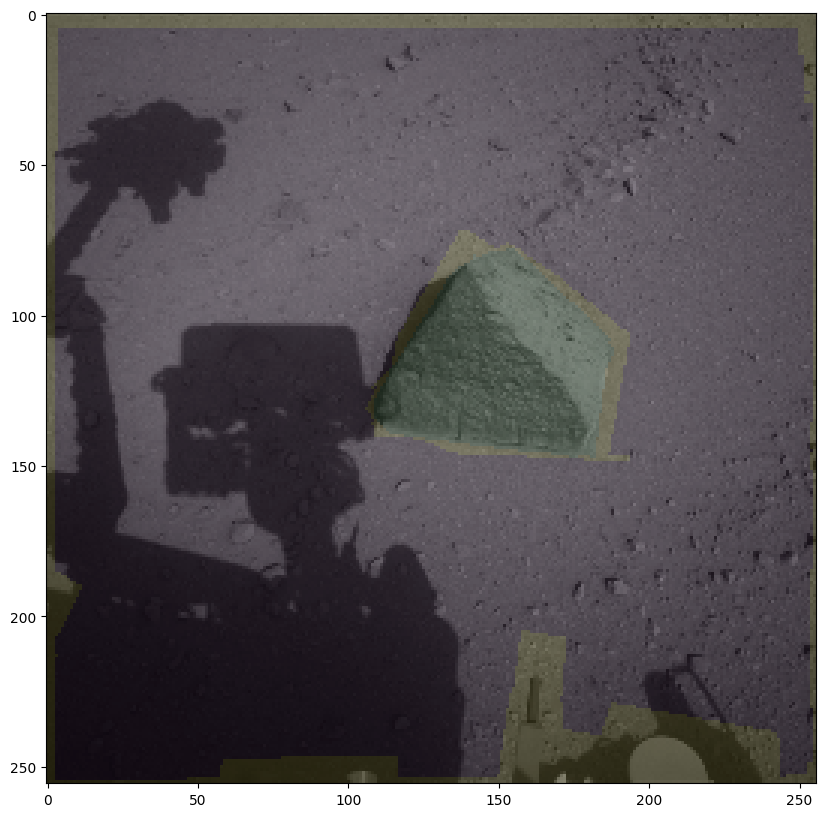

In [12]:
print(np.unique(y[255]))

plt.figure(figsize = (10, 10))

plt.imshow(X[255])
plt.imshow(y[255], alpha = 0.1)

plt.show()

In [14]:
n_classes=5
height=256
width=256
channels=3
inputs = Input((height, width, channels))

#Down Sampling
conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
conv_1 = Dropout(0.1)(conv_1)
conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_1)

conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_1)
conv_2 = Dropout(0.1)(conv_2)
conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2)
pool_2 = MaxPooling2D((2, 2))(conv_2)

conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_2)
conv_3 = Dropout(0.1)(conv_3)
conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3)
pool_3 = MaxPooling2D((2, 2))(conv_3)

conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_3)
conv_4 = Dropout(0.1)(conv_4)
conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_4)
pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_4)
conv_5 = Dropout(0.2)(conv_5)
conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_5)

#Up Sampling
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_5)
u6 = concatenate([u6, conv_4])
conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
conv_6 = Dropout(0.2)(conv_6)
conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv_6)
u7 = concatenate([u7, conv_3])
conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
conv_7 = Dropout(0.1)(conv_7)
conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_7)
u8 = concatenate([u8, conv_2])
conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
conv_8 = Dropout(0.2)(conv_8)
conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
u9 = concatenate([u9, conv_1], axis=3)
conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
conv_9 = Dropout(0.1)(conv_9)
conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)

outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv_9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [15]:
model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [17]:
num_classes = 5

# Création d'une liste vide pour stocker les masques
mask_list = []

for i in range(1, num_classes + 1):  # Assurez-vous que les classes commencent à 1
    mask = (y_train == i).astype(np.float32)  # Crée un masque pour chaque classe
    mask_list.append(mask)

# Empilage des masques pour former 5 canaux
y_train = np.stack(mask_list, axis=-1)

In [18]:
%%time
MODEL = "unet_4deep_16in_16k_img_256pix"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL),
                                            monitor="val_loss",
                                            save_best_only = False)

LR_reducer = callbacks.ReduceLROnPlateau(patience = 3,
                                         monitor="val_loss",
                                         factor = 0.1,
                                         min_lr = 0
                                        )

early_stopper = callbacks.EarlyStopping(patience = 5,
                                        monitor="val_loss",
                                        restore_best_weights=True)



history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=100,
          validation_split=0.3,
          callbacks = [modelCheckpoint, LR_reducer, early_stopper],
          verbose=1)


Epoch 1/100
210/210 [==============================] - 50s 127ms/step - loss: 1.1882 - iou_score: 0.1416 - val_loss: 1.0896 - val_iou_score: 0.1804 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - 17s 83ms/step - loss: 1.0172 - iou_score: 0.2233 - val_loss: 1.0028 - val_iou_score: 0.2558 - lr: 0.0010
Epoch 3/100
210/210 [==============================] - 18s 84ms/step - loss: 0.9535 - iou_score: 0.2683 - val_loss: 0.9568 - val_iou_score: 0.2708 - lr: 0.0010
Epoch 4/100
210/210 [==============================] - 18s 84ms/step - loss: 0.9090 - iou_score: 0.2954 - val_loss: 0.8712 - val_iou_score: 0.3243 - lr: 0.0010
Epoch 5/100
210/210 [==============================] - 17s 83ms/step - loss: 0.8761 - iou_score: 0.3162 - val_loss: 0.8927 - val_iou_score: 0.3067 - lr: 0.0010
Epoch 6/100
210/210 [==============================] - 18s 84ms/step - loss: 0.8600 - iou_score: 0.3262 - val_loss: 0.8446 - val_iou_score: 0.3299 - lr: 0.0010
Epoch 7/100
210/210 [==============================] - 17s 83ms/step - loss: 0.8308 - iou_score: 0.3439 - val_loss: 0.7946 - val_iou_score: 0.3647 - lr: 0.0010
Epoch 8/100
210/210 [==============================]

In [20]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    # ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['iou_score'], label='train iou'  + exp_name)
    ax2.plot(history.history['val_iou_score'], label='val iou'  + exp_name)
    # ax2.set_ylim(0, 0.5)
    ax2.set_title('iou')
    ax2.legend()
    plt.show()

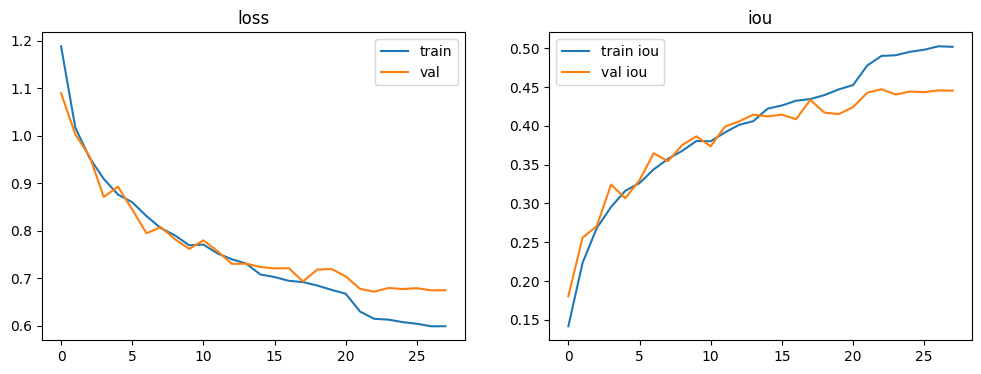

In [21]:
plot_history(history)

In [12]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()


In [ ]:
# %%time
# es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
# #modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


# history = model.fit(X_train, y_train,
#           batch_size=16,
#           epochs=10,
#           validation_split=0.3,
#           callbacks=[es],
#           verbose=1)


Epoch 1/10
16/16 [==============================] - 26s 1s/step - loss: 1.4578 - iou_score: 0.0815 - val_loss: 1.2656 - val_iou_score: 0.0958
Epoch 2/10
16/16 [==============================] - 23s 1s/step - loss: 1.2874 - iou_score: 0.1014 - val_loss: 1.2581 - val_iou_score: 0.0978
Epoch 3/10
16/16 [==============================] - 24s 2s/step - loss: 1.2503 - iou_score: 0.1036 - val_loss: 1.2078 - val_iou_score: 0.1063
Epoch 4/10
16/16 [==============================] - 24s 2s/step - loss: 1.2265 - iou_score: 0.1115 - val_loss: 1.1993 - val_iou_score: 0.1112
Epoch 5/10
16/16 [==============================] - 24s 2s/step - loss: 1.2203 - iou_score: 0.1126 - val_loss: 1.2105 - val_iou_score: 0.1098
Epoch 6/10
16/16 [==============================] - 24s 1s/step - loss: 1.2093 - iou_score: 0.1202 - val_loss: 1.1699 - val_iou_score: 0.1257
Epoch 7/10
16/16 [==============================] - 24s 2s/step - loss: 1.1916 - iou_score: 0.1295 - val_loss: 1.1409 - val_iou_score: 0.1381
Epoch 

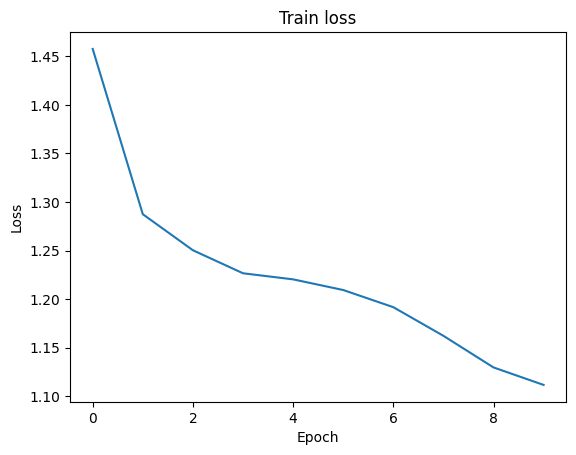

In [ ]:
# plot_history(history)

In [ ]:
%%time
es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
#modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


history = model.fit(X_train, y_train,
          batch_size=16,
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose=1)

Epoch 1/100
16/16 [==============================] - 24s 1s/step - loss: 1.1298 - iou_score: 0.1686 - val_loss: 1.1122 - val_iou_score: 0.1594
Epoch 2/100
16/16 [==============================] - 21s 1s/step - loss: 1.0876 - iou_score: 0.1826 - val_loss: 1.1037 - val_iou_score: 0.1642
Epoch 3/100
16/16 [==============================] - 21s 1s/step - loss: 1.0782 - iou_score: 0.1859 - val_loss: 1.1144 - val_iou_score: 0.1632
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 1.0691 - iou_score: 0.1947 - val_loss: 1.1006 - val_iou_score: 0.1652
Epoch 5/100
16/16 [==============================] - 22s 1s/step - loss: 1.0615 - iou_score: 0.1987 - val_loss: 1.0589 - val_iou_score: 0.1860
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 1.0442 - iou_score: 0.2079 - val_loss: 1.0723 - val_iou_score: 0.1840
Epoch 7/100
16/16 [==============================] - 22s 1s/step - loss: 1.0355 - iou_score: 0.2171 - val_loss: 1.0453 - val_iou_score: 0.1932

In [ ]:
history.history

{'loss': [1.1297701597213745,
  1.0876463651657104,
  1.0782088041305542,
  1.0690951347351074,
  1.0615358352661133,
  1.0441967248916626,
  1.0354652404785156,
  1.0449689626693726,
  1.0198251008987427],
 'iou_score': [0.1685541868209839,
  0.18260574340820312,
  0.18585895001888275,
  0.19469091296195984,
  0.19866147637367249,
  0.20785057544708252,
  0.2171015739440918,
  0.2078864872455597,
  0.21589668095111847],
 'val_loss': [1.1121928691864014,
  1.1037356853485107,
  1.1143794059753418,
  1.1005871295928955,
  1.0588997602462769,
  1.0723048448562622,
  1.04526686668396,
  1.0609480142593384,
  1.080163836479187],
 'val_iou_score': [0.15940341353416443,
  0.1642206758260727,
  0.16320741176605225,
  0.16516396403312683,
  0.18596236407756805,
  0.18400494754314423,
  0.1931913048028946,
  0.1878410279750824,
  0.17755672335624695]}

<function matplotlib.pyplot.show(close=None, block=None)>

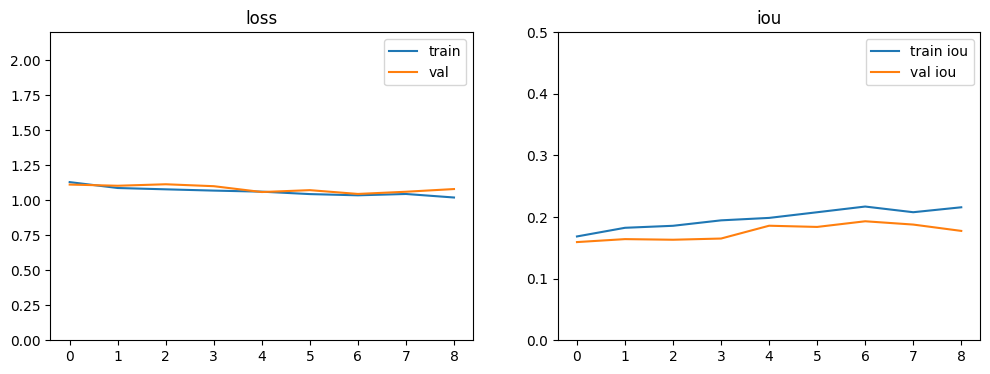

In [ ]:
# def plot_history(history, title='', axs=None, exp_name=""):
#     if axs is not None:
#         ax1, ax2 = axs
#     else:
#         f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

#     if len(exp_name) > 0 and exp_name[0] != '_':
#         exp_name = '_' + exp_name
#     ax1.plot(history.history['loss'], label = 'train' + exp_name)
#     ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
#     ax1.set_ylim(0., 2.2)
#     ax1.set_title('loss')
#     ax1.legend()

#     ax2.plot(history.history['iou_score'], label='train iou'  + exp_name)
#     ax2.plot(history.history['val_iou_score'], label='val iou'  + exp_name)
#     ax2.set_ylim(0, 0.5)
#     ax2.set_title('iou')
#     ax2.legend()
#     return (ax1, ax2)

# plot_history(history)
# plt.show